## Chlorophyll-a forecasting using LSTM Model



#### Getting Started:
1. Before running the notebook, please make sure to have the following python version and libraries are installed <br>
- python 3.9.12
- pytorch (https://pytorch.org/get-started/locally/)

2. Create an account in Weights and Biases (WANDB) (https://wandb.ai/home). While running the notebook, you maybe prompted to enter the WANDB username

<br>
The requirements.txt file lists the basic libraries require. Running the following cell should install all of them (in case they are not already installed). 

In case, any library is missed here, you would be prompted with an ImportError. In such case, just install it with pip (google -> pip install library_name)

In [1]:
!pip install -r requirements.txt

In [2]:
import random
import pandas as pd
import numpy as np
from tqdm import trange
import os
import datetime
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch import optim

from utils import Utils
from encoder_decoder import seq2seq

import warnings
warnings.filterwarnings('ignore')

wandb: Currently logged in as: rladwig (computational-limnology). Use `wandb login --relogin` to force relogin


## 0. GPU Selection
Check if GPU is available on the machine the notebook is running. If yes, then assign a GPU, else run it on CPU

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


## 1. Parameter setting

#### Specify the wandb project and wandb run
wandb refers to Weights and Biases. Integrating this tool into the notebook will allow it to access the run details and generate train and test curves, among many other information

In [4]:
# wandb project name
wandb_project = "mcl_lstm"

# wandb run name
wandb_run = "ice_run_{}_{}".format(str(datetime.datetime.now().date()), str(datetime.datetime.now().time()))

# Yes if we want wandb to save our python code, else no
save_code = True

#### Specify the input path (where the dataset is stored) and dataset name
Note: For different dataset, the processing/handling can/will be different. In this notebook, FCR (observational) data has been considered. It also has a metadata file that stores the column names and types. 
<br>
For the purpose of the tutorial, the notebook is kept simple, hence, going with FCR data for now

In [5]:
# Input path
path = './'

# Name of the file
file = '../1_trainingData/all_data_lake_modeling_in_time_perRow.csv'

# Name of the metadata file
#../metadata = 'LSTM_dataset_column_key_07OCT22.csv'

#### Specify the Time-series specific parameters

In [6]:
# Lookback window
input_window = 24*3

# horizon window
output_window = 24*3

# stride - While creating samples (lookback window + horizon window = 1 sample) define the amount of stride the sliding window needs to take
stride = 1

# The ratio in which train and test data is split. If it is 0.8, then first 80% of data goes into train and remaining 20% into test
split_ratio = 0.6

#### Specify the model specific parameters

In [7]:
# Types of Model include: LSTM, GRU, RNN
model_type = "LSTM"

# Number of layers in our deep learning model
num_layers = 2

# Hidden cell (RNN/LSTM/GRU) size
hidden_feature_size = 32

# Output size of our encoder_decoder model, i.e. number of target variables
output_size = 50

'''
Model Training parameters
'''
# batch_size during training
batch_size = 32

# Number of epochs we want to train the model for (1 epoch = 1 pass of the complete training data through the model)
epochs = 100

# Learning rate specifies the rate at which we want to update the model parameters after every training pass
learning_rate = 0.001

# Eval freq says how frequently during training do you want to evaluate your model on the validation data (to see its performance on non-training data)
eval_freq = 1 # logic is -> if iteration_num % eval_freq == 0 -> then perform evaluation

# While generating the training batches do we want the generator to shuffle the batches?
batch_shuffle = True

# Dropout is a form of regularization
dropout = 0.0

'''
Learning rate scheduler parameters
'''
max_lr=5e-3
div_factor=100
pct_start=0.05 
anneal_strategy='cos'
final_div_factor=10000.0

'''
Parameters for early stopping
'''
# Set to True if we want Early stopping
early_stop = False

# If there is no improvement for a 'thres' number of epocs stop the training process
thres=5

# Quantifying the improvement. If the validation loss is greater than min_val_loss_so_far + delta for thres number of iterations stop the training
delta=0.5

'''
Other parameters
'''
# Specify the amount of L2 regularization to be applied.
weight_decay=0.0

# Specify the percentage of times we want to enforce teacher forcing
teacher_forcing_ratio = 0.0
training_prediction = 'recursive'

## 2. Data Processing

#### Read the metadata file

In [8]:
depth_steps = 25 * 2 

depth_list = np.array(list(range(1, depth_steps+1))   )*0.5



In [9]:
incoming_temp = ['temp_heat01_{}'.format(x) for x in depth_list]
outgoing_temp = ['temp_ice02_{}'.format(x) for x in depth_list]

dx = pd.read_csv(os.path.join(path,file))

#feature_cols = ['AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
#                'lightExtinct_m-1', 'ShearStress_Nm-2',
#                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice','Volume_m2','Osgood','MaxDepth_m',
#                'MeanDepth_m','Area_m2'] + incoming_temp

feature_cols = ['AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearStress_Nm-2',
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice'] + incoming_temp

date_col = ['time']

target_cols = outgoing_temp

In [10]:
#dx = pd.read_csv(os.path.join(path, metadata))

# Extract all col names from Metadata
#feature_cols = dx[dx['column_type']=='feature']['column_names'].tolist()  # feature colums represent the input drivers
#target_cols = dx[dx['column_type']=='target']['column_names'].tolist()   # target column represent the chlorophyll values
#date_col = dx[dx['column_type']=='date']['column_names'].tolist()[0]    # date column stores the date timeline

In [11]:
# Specify whether we want to add chlorophyll to the input feature set
#feature_cols += target_cols
feature_cols

['AirTemp_degC',
 'Longwave_Wm-2',
 'Latent_Wm-2',
 'Sensible_Wm-2',
 'Shortwave_Wm-2',
 'lightExtinct_m-1',
 'ShearStress_Nm-2',
 'day_of_year',
 'time_of_day',
 'ice',
 'snow',
 'snowice',
 'temp_heat01_0.5',
 'temp_heat01_1.0',
 'temp_heat01_1.5',
 'temp_heat01_2.0',
 'temp_heat01_2.5',
 'temp_heat01_3.0',
 'temp_heat01_3.5',
 'temp_heat01_4.0',
 'temp_heat01_4.5',
 'temp_heat01_5.0',
 'temp_heat01_5.5',
 'temp_heat01_6.0',
 'temp_heat01_6.5',
 'temp_heat01_7.0',
 'temp_heat01_7.5',
 'temp_heat01_8.0',
 'temp_heat01_8.5',
 'temp_heat01_9.0',
 'temp_heat01_9.5',
 'temp_heat01_10.0',
 'temp_heat01_10.5',
 'temp_heat01_11.0',
 'temp_heat01_11.5',
 'temp_heat01_12.0',
 'temp_heat01_12.5',
 'temp_heat01_13.0',
 'temp_heat01_13.5',
 'temp_heat01_14.0',
 'temp_heat01_14.5',
 'temp_heat01_15.0',
 'temp_heat01_15.5',
 'temp_heat01_16.0',
 'temp_heat01_16.5',
 'temp_heat01_17.0',
 'temp_heat01_17.5',
 'temp_heat01_18.0',
 'temp_heat01_18.5',
 'temp_heat01_19.0',
 'temp_heat01_19.5',
 'temp_he

In [12]:
target_cols

['temp_ice02_0.5',
 'temp_ice02_1.0',
 'temp_ice02_1.5',
 'temp_ice02_2.0',
 'temp_ice02_2.5',
 'temp_ice02_3.0',
 'temp_ice02_3.5',
 'temp_ice02_4.0',
 'temp_ice02_4.5',
 'temp_ice02_5.0',
 'temp_ice02_5.5',
 'temp_ice02_6.0',
 'temp_ice02_6.5',
 'temp_ice02_7.0',
 'temp_ice02_7.5',
 'temp_ice02_8.0',
 'temp_ice02_8.5',
 'temp_ice02_9.0',
 'temp_ice02_9.5',
 'temp_ice02_10.0',
 'temp_ice02_10.5',
 'temp_ice02_11.0',
 'temp_ice02_11.5',
 'temp_ice02_12.0',
 'temp_ice02_12.5',
 'temp_ice02_13.0',
 'temp_ice02_13.5',
 'temp_ice02_14.0',
 'temp_ice02_14.5',
 'temp_ice02_15.0',
 'temp_ice02_15.5',
 'temp_ice02_16.0',
 'temp_ice02_16.5',
 'temp_ice02_17.0',
 'temp_ice02_17.5',
 'temp_ice02_18.0',
 'temp_ice02_18.5',
 'temp_ice02_19.0',
 'temp_ice02_19.5',
 'temp_ice02_20.0',
 'temp_ice02_20.5',
 'temp_ice02_21.0',
 'temp_ice02_21.5',
 'temp_ice02_22.0',
 'temp_ice02_22.5',
 'temp_ice02_23.0',
 'temp_ice02_23.5',
 'temp_ice02_24.0',
 'temp_ice02_24.5',
 'temp_ice02_25.0']

#### Create an utility object
An object of the Utils class, it contains all the utility functions like splitting train and test data, normalizing the data, etc.

In [13]:
'''
Utility instance - to perform data processing, train test split
'''
utils = Utils(num_features=len(feature_cols), inp_cols=feature_cols, target_cols=target_cols, date_col=date_col,
              input_window=input_window, output_window=output_window, num_out_features=output_size, stride=stride)

#### Read the dataset

In [14]:
'''
Read data
'''
df = pd.read_csv(path+file)

#### Train Test split
Ideally, a 3-way split is done - train, val and test. The validation split is generally used to tune the hyper-parameters during training. Once the hyper-parameters are tuned, the model
is re-trained on the train+val data. To keep the notebook short and simple, hyper-parameter tuning is not included

In [15]:
'''
Split data into train and test
'''
df_train, df_test = utils.train_test_split(df, split_ratio=split_ratio)

In [16]:
def cycle_encode(x, period):
    sin = np.sin(2*math.pi*x/period)
    cos = np.cos(2*math.pi*x/period)
    
    return sin, cos

In [17]:
train_doy_sin, train_doy_cos = cycle_encode(df_train.day_of_year.values, 365)

In [18]:
train_tod_sin, train_tod_cos = cycle_encode(df_train.time_of_day.values, 24)

In [19]:
test_doy_sin, test_doy_cos = cycle_encode(df_test.day_of_year.values, 365)

In [20]:
test_tod_sin, test_tod_cos = cycle_encode(df_test.time_of_day.values, 24)

In [21]:
feature_cols.remove('day_of_year')
feature_cols.remove('time_of_day')
feature_cols

['AirTemp_degC',
 'Longwave_Wm-2',
 'Latent_Wm-2',
 'Sensible_Wm-2',
 'Shortwave_Wm-2',
 'lightExtinct_m-1',
 'ShearStress_Nm-2',
 'ice',
 'snow',
 'snowice',
 'temp_heat01_0.5',
 'temp_heat01_1.0',
 'temp_heat01_1.5',
 'temp_heat01_2.0',
 'temp_heat01_2.5',
 'temp_heat01_3.0',
 'temp_heat01_3.5',
 'temp_heat01_4.0',
 'temp_heat01_4.5',
 'temp_heat01_5.0',
 'temp_heat01_5.5',
 'temp_heat01_6.0',
 'temp_heat01_6.5',
 'temp_heat01_7.0',
 'temp_heat01_7.5',
 'temp_heat01_8.0',
 'temp_heat01_8.5',
 'temp_heat01_9.0',
 'temp_heat01_9.5',
 'temp_heat01_10.0',
 'temp_heat01_10.5',
 'temp_heat01_11.0',
 'temp_heat01_11.5',
 'temp_heat01_12.0',
 'temp_heat01_12.5',
 'temp_heat01_13.0',
 'temp_heat01_13.5',
 'temp_heat01_14.0',
 'temp_heat01_14.5',
 'temp_heat01_15.0',
 'temp_heat01_15.5',
 'temp_heat01_16.0',
 'temp_heat01_16.5',
 'temp_heat01_17.0',
 'temp_heat01_17.5',
 'temp_heat01_18.0',
 'temp_heat01_18.5',
 'temp_heat01_19.0',
 'temp_heat01_19.5',
 'temp_heat01_20.0',
 'temp_heat01_20.5',

#### Normalize the data
Standard normalization - 0 mean and 1 standard deviation

In [22]:
utils.inp_cols

['AirTemp_degC',
 'Longwave_Wm-2',
 'Latent_Wm-2',
 'Sensible_Wm-2',
 'Shortwave_Wm-2',
 'lightExtinct_m-1',
 'ShearStress_Nm-2',
 'ice',
 'snow',
 'snowice',
 'temp_heat01_0.5',
 'temp_heat01_1.0',
 'temp_heat01_1.5',
 'temp_heat01_2.0',
 'temp_heat01_2.5',
 'temp_heat01_3.0',
 'temp_heat01_3.5',
 'temp_heat01_4.0',
 'temp_heat01_4.5',
 'temp_heat01_5.0',
 'temp_heat01_5.5',
 'temp_heat01_6.0',
 'temp_heat01_6.5',
 'temp_heat01_7.0',
 'temp_heat01_7.5',
 'temp_heat01_8.0',
 'temp_heat01_8.5',
 'temp_heat01_9.0',
 'temp_heat01_9.5',
 'temp_heat01_10.0',
 'temp_heat01_10.5',
 'temp_heat01_11.0',
 'temp_heat01_11.5',
 'temp_heat01_12.0',
 'temp_heat01_12.5',
 'temp_heat01_13.0',
 'temp_heat01_13.5',
 'temp_heat01_14.0',
 'temp_heat01_14.5',
 'temp_heat01_15.0',
 'temp_heat01_15.5',
 'temp_heat01_16.0',
 'temp_heat01_16.5',
 'temp_heat01_17.0',
 'temp_heat01_17.5',
 'temp_heat01_18.0',
 'temp_heat01_18.5',
 'temp_heat01_19.0',
 'temp_heat01_19.5',
 'temp_heat01_20.0',
 'temp_heat01_20.5',

In [23]:
'''
Data Scaling
'''
df_train = utils.normalize(df_train)

In [24]:
df_test = utils.normalize(df_test, use_stat=True)

In [25]:
feature_cols += ['doy_sin', 'doy_cos', 'tod_sin', 'tod_cos']

In [26]:
utils.inp_cols

['AirTemp_degC',
 'Longwave_Wm-2',
 'Latent_Wm-2',
 'Sensible_Wm-2',
 'Shortwave_Wm-2',
 'lightExtinct_m-1',
 'ShearStress_Nm-2',
 'ice',
 'snow',
 'snowice',
 'temp_heat01_0.5',
 'temp_heat01_1.0',
 'temp_heat01_1.5',
 'temp_heat01_2.0',
 'temp_heat01_2.5',
 'temp_heat01_3.0',
 'temp_heat01_3.5',
 'temp_heat01_4.0',
 'temp_heat01_4.5',
 'temp_heat01_5.0',
 'temp_heat01_5.5',
 'temp_heat01_6.0',
 'temp_heat01_6.5',
 'temp_heat01_7.0',
 'temp_heat01_7.5',
 'temp_heat01_8.0',
 'temp_heat01_8.5',
 'temp_heat01_9.0',
 'temp_heat01_9.5',
 'temp_heat01_10.0',
 'temp_heat01_10.5',
 'temp_heat01_11.0',
 'temp_heat01_11.5',
 'temp_heat01_12.0',
 'temp_heat01_12.5',
 'temp_heat01_13.0',
 'temp_heat01_13.5',
 'temp_heat01_14.0',
 'temp_heat01_14.5',
 'temp_heat01_15.0',
 'temp_heat01_15.5',
 'temp_heat01_16.0',
 'temp_heat01_16.5',
 'temp_heat01_17.0',
 'temp_heat01_17.5',
 'temp_heat01_18.0',
 'temp_heat01_18.5',
 'temp_heat01_19.0',
 'temp_heat01_19.5',
 'temp_heat01_20.0',
 'temp_heat01_20.5',

In [27]:
df_train['doy_sin'] = train_doy_sin
df_train['doy_cos'] = train_doy_cos
df_test['doy_sin'] = test_doy_sin
df_test['doy_cos'] = test_doy_cos

In [28]:
df_train['tod_sin'] = train_tod_sin
df_train['tod_cos'] = train_tod_cos
df_test['tod_sin'] = test_tod_sin
df_test['tod_cos'] = test_tod_cos

In [29]:
'''
convert the mean and std to torch
'''
utils.y_mean = torch.tensor(utils.y_mean, device=device)
utils.y_std = torch.tensor(utils.y_std, device=device)

In [30]:
utils.y_mean

tensor([10.0396, 10.1974, 10.2302, 10.2566, 10.2729, 10.2784, 10.2729, 10.2615,
        10.2404, 10.2088, 10.1733, 10.1235, 10.0488,  9.9500,  9.8614,  9.7375,
         9.6213,  9.4919,  9.3382,  9.1919,  9.0202,  8.8065,  8.5467,  8.2931,
         8.0837,  7.8682,  7.6301,  7.4300,  7.2490,  7.0245,  6.7805,  6.5827,
         6.4102,  6.2342,  6.0487,  5.8633,  5.7074,  5.6071,  5.5396,  5.5040,
         5.4898,  5.4743,  5.4829,  5.5077,  5.5382,  5.5724,  5.6064,  5.6394,
         5.6485,  5.6184], device='cuda:0', dtype=torch.float64)

In [31]:
utils.y_std

tensor([9.2538, 9.2370, 9.1708, 9.1109, 9.0553, 8.9986, 8.9421, 8.8888, 8.8343,
        8.7734, 8.7147, 8.6430, 8.5344, 8.4039, 8.2945, 8.1593, 8.0416, 7.8854,
        7.7071, 7.5446, 7.3595, 7.1617, 6.9437, 6.7436, 6.5731, 6.3605, 6.0942,
        5.8814, 5.6644, 5.3623, 5.0458, 4.8156, 4.6251, 4.4228, 4.1846, 3.9359,
        3.7434, 3.6271, 3.5353, 3.4676, 3.3976, 3.2930, 3.2298, 3.1876, 3.1528,
        3.1208, 3.0906, 3.0600, 3.0296, 2.8982], device='cuda:0',
       dtype=torch.float64)

In [32]:
utils.num_features = len(utils.inp_cols)

#### Create train and test samples
Each sample is created using a sliding window. 1 sliding window = 1 lookback window + 1 horizon window = 1 sample

In [33]:
'''
Prepare data : 1 training sample = lookback window + horizon window
'''
Xtrain, Ytrain = utils.windowed_dataset(df_train)
Xtest, Ytest = utils.windowed_dataset(df_test)

In [34]:
Xtrain.shape

(31399, 72, 64)

In [35]:
Ytrain.shape

(31399, 72, 50)

In [36]:
Xtest.shape

(20885, 72, 64)

In [37]:
Ytest.shape

(20885, 72, 50)

#### Datatype conversion to torch

In [38]:
'''
Convert data into torch type
'''
X_train, Y_train, X_test, Y_test = utils.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

## 3. Modeling

#### Define the model

In [39]:
'''
Create the seq2seq model
'''
model = seq2seq(input_size = X_train.shape[2], 
                hidden_size = hidden_feature_size, 
                output_size=output_size,
                model_type=model_type,
                num_layers = num_layers,
                utils=utils,
                dropout=dropout,
                device=device
               )

#### Train the model

In [40]:
'''
Train the model
'''
config = {
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "eval_freq": eval_freq,
    "batch_shuffle": batch_shuffle,
    "dropout":dropout,
    "num_layers": num_layers,
    "hidden_feature_size": hidden_feature_size,
    "model_type": model_type,
    "teacher_forcing_ratio": teacher_forcing_ratio,
    "max_lr": max_lr,
    "div_factor": div_factor,
    "pct_start": pct_start,
    "anneal_strategy": anneal_strategy,
    "final_div_factor": final_div_factor,
    "dataset": file,
    "split_ratio":split_ratio,
    "input_window":input_window,
    "output_window":output_window,
    "early_stop_thres":thres,
    "early_stop_delta":delta,
    "early_stop":early_stop,
    "weight_decay":weight_decay
}
loss, test_rmse, train_rmse = model.train_model(X_train, 
                                                Y_train,
                                                X_test,
                                                Y_test,
                                                target_len = output_window,
                                                config = config,
                                                training_prediction = training_prediction,  
                                                dynamic_tf = False,
                                                project_name = wandb_project,
                                                run_name = wandb_run,
                                                save_code = save_code)

 13%|██████████▎                                                                     | 127/982 [00:11<01:07, 12.75it/s]


 26%|█████████████████████                                                           | 259/982 [00:21<00:57, 12.64it/s]


 40%|███████████████████████████████▊                                                | 391/982 [00:32<00:45, 12.88it/s]


 53%|██████████████████████████████████████████▌                                     | 523/982 [00:42<00:35, 12.79it/s]


 67%|█████████████████████████████████████████████████████▎                          | 655/982 [00:53<00:26, 12.51it/s]


 79%|███████████████████████████████████████████████████████████████▏                | 776/982 [01:03<00:16, 12.40it/s]


 92%|█████████████████████████████████████████████████████████████████████████▊      | 906/982 [01:14<00:06, 12.24it/s]


  5%|████▎                                                                            | 52/982 [00:04<01:14, 12.47it/s]


 19%|██████████████▉                                                                 | 184/982 [00:14<01:02, 12.68it/s]


 32%|█████████████████████████▋                                                      | 316/982 [00:25<00:53, 12.40it/s]


 46%|████████████████████████████████████▍                                           | 448/982 [00:35<00:43, 12.40it/s]


 59%|███████████████████████████████████████████████▎                                | 580/982 [00:46<00:32, 12.34it/s]


 73%|██████████████████████████████████████████████████████████                      | 712/982 [00:56<00:21, 12.35it/s]


 86%|████████████████████████████████████████████████████████████████████▊           | 844/982 [01:06<00:10, 12.75it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▌| 976/982 [01:17<00:00, 12.54it/s]


 12%|█████████▉                                                                      | 122/982 [00:09<01:07, 12.66it/s]


 26%|████████████████████▋                                                           | 254/982 [00:20<00:57, 12.70it/s]


 39%|███████████████████████████████▍                                                | 386/982 [00:30<00:47, 12.56it/s]


 53%|██████████████████████████████████████████▏                                     | 518/982 [00:41<00:36, 12.76it/s]


 66%|████████████████████████████████████████████████████▉                           | 650/982 [00:51<00:26, 12.58it/s]


 80%|███████████████████████████████████████████████████████████████▋                | 782/982 [01:01<00:15, 12.74it/s]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 914/982 [01:12<00:05, 12.56it/s]


  6%|████▉                                                                            | 60/982 [00:04<01:13, 12.50it/s]


 20%|███████████████▋                                                                | 192/982 [00:15<01:02, 12.71it/s]


 33%|██████████████████████████▍                                                     | 324/982 [00:25<00:51, 12.70it/s]


 46%|█████████████████████████████████████▏                                          | 456/982 [00:36<00:41, 12.55it/s]


 60%|███████████████████████████████████████████████▉                                | 588/982 [00:46<00:30, 13.06it/s]


 73%|██████████████████████████████████████████████████████████▋                     | 720/982 [00:56<00:20, 12.66it/s]


 87%|█████████████████████████████████████████████████████████████████████▍          | 852/982 [01:07<00:10, 12.87it/s]


  4%|█▎                               | 4/100 [06:11<2:27:42, 92.32s/it, loss=0.0127, test_rmse=1.07, train_rmse=0.659]


 13%|██████████▌                                                                     | 130/982 [00:10<01:06, 12.74it/s]


 27%|█████████████████████▎                                                          | 262/982 [00:20<00:56, 12.72it/s]


 40%|████████████████████████████████                                                | 394/982 [00:31<00:46, 12.76it/s]


 54%|██████████████████████████████████████████▊                                     | 526/982 [00:41<00:37, 12.24it/s]


 67%|█████████████████████████████████████████████████████▌                          | 658/982 [00:51<00:25, 12.64it/s]


 80%|████████████████████████████████████████████████████████████████▎               | 790/982 [01:02<00:15, 12.37it/s]


 94%|███████████████████████████████████████████████████████████████████████████     | 922/982 [01:12<00:04, 12.63it/s]


  7%|█████▌                                                                           | 68/982 [00:05<01:12, 12.67it/s]


 20%|████████████████▎                                                               | 200/982 [00:15<01:01, 12.72it/s]


 34%|███████████████████████████                                                     | 332/982 [00:26<00:51, 12.64it/s]


 47%|█████████████████████████████████████▊                                          | 464/982 [00:36<00:41, 12.55it/s]


 61%|████████████████████████████████████████████████▌                               | 596/982 [00:47<00:30, 12.70it/s]


 74%|███████████████████████████████████████████████████████████▎                    | 728/982 [00:57<00:19, 12.72it/s]


 88%|██████████████████████████████████████████████████████████████████████          | 860/982 [01:07<00:09, 12.69it/s]


  1%|▌                                                                                 | 6/982 [00:00<01:15, 12.88it/s]


 14%|███████████▏                                                                    | 138/982 [00:10<01:06, 12.67it/s]


 27%|█████████████████████▉                                                          | 270/982 [00:21<00:56, 12.57it/s]


 41%|████████████████████████████████▋                                               | 402/982 [00:31<00:45, 12.80it/s]


 54%|███████████████████████████████████████████▌                                    | 534/982 [00:42<00:35, 12.67it/s]


 68%|██████████████████████████████████████████████████████▎                         | 666/982 [00:52<00:25, 12.62it/s]


 81%|█████████████████████████████████████████████████████████████████               | 798/982 [01:03<00:14, 12.51it/s]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 930/982 [01:13<00:04, 12.56it/s]


  8%|██████▎                                                                          | 76/982 [00:06<01:13, 12.38it/s]


 21%|████████████████▉                                                               | 208/982 [00:16<01:00, 12.82it/s]


 35%|███████████████████████████▋                                                    | 340/982 [00:26<00:51, 12.58it/s]


 48%|██████████████████████████████████████▍                                         | 472/982 [00:37<00:40, 12.53it/s]


 62%|█████████████████████████████████████████████████▏                              | 604/982 [00:47<00:29, 12.70it/s]


 75%|███████████████████████████████████████████████████████████▉                    | 736/982 [00:58<00:19, 12.74it/s]


 88%|██████████████████████████████████████████████████████████████████████▋         | 868/982 [01:08<00:08, 12.69it/s]


  1%|█▏                                                                               | 14/982 [00:01<01:16, 12.58it/s]


 15%|███████████▉                                                                    | 146/982 [00:11<01:05, 12.73it/s]


 28%|██████████████████████▋                                                         | 278/982 [00:21<00:55, 12.79it/s]


 42%|█████████████████████████████████▍                                              | 410/982 [00:32<00:45, 12.54it/s]


 55%|████████████████████████████████████████████▏                                   | 542/982 [00:42<00:35, 12.52it/s]


 69%|██████████████████████████████████████████████████████▉                         | 674/982 [00:53<00:24, 12.55it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 806/982 [01:03<00:13, 12.70it/s]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 938/982 [01:14<00:03, 12.53it/s]


  9%|██████▉                                                                          | 84/982 [00:06<01:10, 12.74it/s]


 22%|█████████████████▌                                                              | 216/982 [00:16<01:00, 12.74it/s]


 35%|████████████████████████████▎                                                   | 348/982 [00:27<00:49, 12.75it/s]


 49%|███████████████████████████████████████                                         | 480/982 [00:37<00:39, 12.70it/s]


 62%|█████████████████████████████████████████████████▊                              | 612/982 [00:48<00:28, 13.11it/s]


 76%|████████████████████████████████████████████████████████████▌                   | 744/982 [00:58<00:18, 12.62it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 876/982 [01:09<00:08, 12.77it/s]


  2%|█▊                                                                               | 22/982 [00:01<01:16, 12.61it/s]


 16%|████████████▌                                                                   | 154/982 [00:12<01:03, 13.13it/s]


 29%|███████████████████████▎                                                        | 286/982 [00:22<00:54, 12.77it/s]


 43%|██████████████████████████████████                                              | 418/982 [00:33<00:44, 12.57it/s]


 56%|████████████████████████████████████████████▊                                   | 550/982 [00:43<00:33, 12.75it/s]


 69%|███████████████████████████████████████████████████████▌                        | 682/982 [00:53<00:23, 12.84it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 814/982 [01:04<00:13, 12.30it/s]


 96%|█████████████████████████████████████████████████████████████████████████████   | 946/982 [01:14<00:02, 12.80it/s]


  9%|███████▌                                                                         | 92/982 [00:07<01:07, 13.18it/s]


 23%|██████████████████▏                                                             | 224/982 [00:17<00:59, 12.84it/s]


 36%|█████████████████████████████                                                   | 356/982 [00:27<00:49, 12.53it/s]


 50%|███████████████████████████████████████▊                                        | 488/982 [00:38<00:38, 12.74it/s]


 63%|██████████████████████████████████████████████████▌                             | 620/982 [00:48<00:27, 13.12it/s]


 77%|█████████████████████████████████████████████████████████████▎                  | 752/982 [00:59<00:17, 12.83it/s]


 90%|████████████████████████████████████████████████████████████████████████        | 884/982 [01:09<00:07, 12.68it/s]


  3%|██▍                                                                              | 30/982 [00:02<01:13, 12.97it/s]


 16%|█████████████▏                                                                  | 162/982 [00:12<01:02, 13.13it/s]


 30%|███████████████████████▉                                                        | 294/982 [00:23<00:54, 12.57it/s]


 43%|██████████████████████████████████▋                                             | 426/982 [00:33<00:43, 12.73it/s]


 57%|█████████████████████████████████████████████▍                                  | 558/982 [00:43<00:33, 12.72it/s]


 70%|████████████████████████████████████████████████████████▏                       | 690/982 [00:54<00:23, 12.59it/s]


 84%|██████████████████████████████████████████████████████████████████▉             | 822/982 [01:04<00:12, 12.73it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 954/982 [01:15<00:02, 12.37it/s]


 10%|████████▏                                                                       | 100/982 [00:07<01:07, 13.02it/s]


 24%|██████████████████▉                                                             | 232/982 [00:18<00:58, 12.85it/s]


 37%|█████████████████████████████▋                                                  | 364/982 [00:28<00:48, 12.75it/s]


 51%|████████████████████████████████████████▍                                       | 496/982 [00:38<00:38, 12.73it/s]


 64%|███████████████████████████████████████████████████▏                            | 628/982 [00:49<00:27, 12.76it/s]


 77%|█████████████████████████████████████████████████████████████▉                  | 760/982 [00:59<00:17, 12.72it/s]


 91%|████████████████████████████████████████████████████████████████████████▋       | 892/982 [01:09<00:07, 12.77it/s]


  4%|███▏                                                                             | 38/982 [00:02<01:11, 13.20it/s]


 17%|█████████████▊                                                                  | 170/982 [00:13<01:02, 12.96it/s]


 31%|████████████████████████▌                                                       | 302/982 [00:23<00:53, 12.73it/s]


 44%|███████████████████████████████████▎                                            | 434/982 [00:33<00:41, 13.12it/s]


 58%|██████████████████████████████████████████████                                  | 566/982 [00:44<00:32, 12.75it/s]


 71%|████████████████████████████████████████████████████████▊                       | 698/982 [00:54<00:22, 12.55it/s]


 85%|███████████████████████████████████████████████████████████████████▌            | 830/982 [01:05<00:11, 12.72it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 962/982 [01:15<00:01, 12.73it/s]


 11%|████████▊                                                                       | 108/982 [00:08<01:07, 12.93it/s]


 24%|███████████████████▌                                                            | 240/982 [00:18<00:58, 12.74it/s]


 38%|██████████████████████████████▎                                                 | 372/982 [00:29<00:47, 12.76it/s]


 51%|████████████████████████████████████████▌                                       | 498/982 [00:40<00:56,  8.50it/s]


 64%|███████████████████████████████████████████████████                             | 627/982 [00:51<00:28, 12.36it/s]


 77%|█████████████████████████████████████████████████████████████▊                  | 759/982 [01:02<00:17, 12.73it/s]


 91%|████████████████████████████████████████████████████████████████████████▌       | 891/982 [01:12<00:07, 12.60it/s]


  4%|███▏                                                                             | 38/982 [00:02<01:13, 12.84it/s]


 17%|█████████████▊                                                                  | 170/982 [00:13<01:03, 12.76it/s]


 31%|████████████████████████▌                                                       | 302/982 [00:23<00:53, 12.70it/s]


 44%|███████████████████████████████████▎                                            | 434/982 [00:33<00:42, 12.76it/s]


 58%|██████████████████████████████████████████████                                  | 566/982 [00:44<00:32, 12.74it/s]


 71%|████████████████████████████████████████████████████████▊                       | 698/982 [00:54<00:22, 12.63it/s]


 85%|███████████████████████████████████████████████████████████████████▌            | 830/982 [01:05<00:12, 12.48it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 962/982 [01:15<00:01, 12.72it/s]


 11%|████████▊                                                                       | 108/982 [00:08<01:08, 12.68it/s]


 24%|███████████████████▌                                                            | 240/982 [00:18<00:58, 12.71it/s]


 38%|██████████████████████████████▎                                                 | 372/982 [00:29<00:47, 12.76it/s]


 51%|█████████████████████████████████████████                                       | 504/982 [00:39<00:37, 12.78it/s]


 65%|███████████████████████████████████████████████████▊                            | 636/982 [00:49<00:27, 12.73it/s]


 78%|██████████████████████████████████████████████████████████████▌                 | 768/982 [01:00<00:16, 12.75it/s]


 92%|█████████████████████████████████████████████████████████████████████████▎      | 900/982 [01:10<00:06, 12.73it/s]


  5%|███▊                                                                             | 46/982 [00:03<01:13, 12.82it/s]


 18%|██████████████▌                                                                 | 178/982 [00:13<01:02, 12.82it/s]


 32%|█████████████████████████▎                                                      | 310/982 [00:24<00:52, 12.69it/s]


 45%|████████████████████████████████████                                            | 442/982 [00:34<00:42, 12.68it/s]


 58%|██████████████████████████████████████████████▊                                 | 574/982 [00:44<00:32, 12.64it/s]


 72%|█████████████████████████████████████████████████████████▌                      | 706/982 [00:55<00:21, 12.71it/s]


 85%|████████████████████████████████████████████████████████████████████▎           | 838/982 [01:05<00:11, 12.73it/s]


 99%|███████████████████████████████████████████████████████████████████████████████ | 970/982 [01:16<00:00, 12.74it/s]


 12%|█████████▍                                                                      | 116/982 [00:09<01:07, 12.87it/s]


 25%|████████████████████▏                                                           | 248/982 [00:19<00:57, 12.74it/s]


 39%|██████████████████████████████▉                                                 | 380/982 [00:29<00:47, 12.75it/s]


 52%|█████████████████████████████████████████▋                                      | 512/982 [00:40<00:36, 12.74it/s]


 66%|████████████████████████████████████████████████████▍                           | 644/982 [00:50<00:26, 12.75it/s]


 79%|███████████████████████████████████████████████████████████████▏                | 776/982 [01:00<00:16, 12.76it/s]


 92%|█████████████████████████████████████████████████████████████████████████▉      | 908/982 [01:11<00:05, 12.47it/s]


  5%|████▍                                                                            | 54/982 [00:04<01:11, 13.05it/s]


 19%|███████████████▏                                                                | 186/982 [00:14<01:02, 12.82it/s]


 32%|█████████████████████████▉                                                      | 318/982 [00:24<00:52, 12.74it/s]


 46%|████████████████████████████████████▋                                           | 450/982 [00:35<00:41, 12.71it/s]


 59%|███████████████████████████████████████████████▍                                | 582/982 [00:45<00:31, 12.56it/s]


 73%|██████████████████████████████████████████████████████████▏                     | 714/982 [00:56<00:21, 12.38it/s]


 86%|████████████████████████████████████████████████████████████████████▉           | 846/982 [01:06<00:10, 12.76it/s]


100%|███████████████████████████████████████████████████████████████████████████████▋| 978/982 [01:17<00:00, 12.45it/s]


 13%|██████████                                                                      | 124/982 [00:09<01:07, 12.68it/s]


 26%|████████████████████▊                                                           | 256/982 [00:19<00:58, 12.51it/s]


 40%|███████████████████████████████▌                                                | 388/982 [00:30<00:46, 12.68it/s]


 53%|██████████████████████████████████████████▎                                     | 520/982 [00:40<00:36, 12.71it/s]


 66%|█████████████████████████████████████████████████████                           | 652/982 [00:51<00:26, 12.55it/s]


 80%|███████████████████████████████████████████████████████████████▊                | 784/982 [01:01<00:15, 12.75it/s]


 93%|██████████████████████████████████████████████████████████████████████████▌     | 916/982 [01:11<00:05, 12.69it/s]


  6%|█████                                                                            | 62/982 [00:04<01:11, 12.88it/s]


 20%|███████████████▊                                                                | 194/982 [00:15<01:01, 12.80it/s]


 33%|██████████████████████████▌                                                     | 326/982 [00:25<00:51, 12.71it/s]


 47%|█████████████████████████████████████▎                                          | 458/982 [00:35<00:42, 12.35it/s]


 60%|████████████████████████████████████████████████                                | 590/982 [00:46<00:30, 12.74it/s]


 74%|██████████████████████████████████████████████████████████▊                     | 722/982 [00:56<00:20, 12.51it/s]


 87%|█████████████████████████████████████████████████████████████████████▌          | 854/982 [01:07<00:10, 12.70it/s]


  0%|                                                                                          | 0/982 [00:00<?, ?it/s]


 13%|██████████▊                                                                     | 132/982 [00:10<01:06, 12.76it/s]


 27%|█████████████████████▌                                                          | 264/982 [00:20<00:56, 12.73it/s]


 40%|████████████████████████████████▎                                               | 396/982 [00:30<00:45, 12.78it/s]


 54%|███████████████████████████████████████████                                     | 528/982 [00:41<00:35, 12.80it/s]


 67%|█████████████████████████████████████████████████████▊                          | 660/982 [00:51<00:25, 12.74it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 792/982 [01:01<00:14, 12.77it/s]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 924/982 [01:12<00:04, 12.73it/s]


  7%|█████▎                                                                           | 65/982 [00:05<01:14, 12.32it/s]


 17%|█████████████▉                                                                  | 171/982 [00:17<02:26,  5.55it/s]


 28%|██████████████████████▌                                                         | 277/982 [00:28<00:56, 12.55it/s]


 42%|█████████████████████████████████▎                                              | 409/982 [00:39<00:45, 12.70it/s]


 55%|████████████████████████████████████████████                                    | 541/982 [00:49<00:34, 12.69it/s]


 69%|██████████████████████████████████████████████████████▊                         | 673/982 [01:00<00:24, 12.72it/s]


 82%|█████████████████████████████████████████████████████████████████▌              | 805/982 [01:10<00:13, 12.75it/s]


 95%|████████████████████████████████████████████████████████████████████████████▎   | 937/982 [01:21<00:03, 12.76it/s]


  9%|██████▉                                                                          | 84/982 [00:06<01:08, 13.02it/s]


 22%|█████████████████▌                                                              | 216/982 [00:16<01:00, 12.74it/s]


 35%|████████████████████████████▎                                                   | 348/982 [00:27<00:49, 12.74it/s]


 49%|███████████████████████████████████████                                         | 480/982 [00:37<00:39, 12.73it/s]


 62%|█████████████████████████████████████████████████▊                              | 612/982 [00:47<00:29, 12.72it/s]


 76%|████████████████████████████████████████████████████████████▌                   | 744/982 [00:58<00:18, 12.57it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 876/982 [01:08<00:08, 12.63it/s]


  2%|█▊                                                                               | 22/982 [00:01<01:16, 12.63it/s]


 16%|████████████▌                                                                   | 154/982 [00:11<01:04, 12.74it/s]


 29%|███████████████████████▎                                                        | 286/982 [00:22<00:54, 12.74it/s]


 43%|██████████████████████████████████                                              | 418/982 [00:32<00:44, 12.74it/s]


 56%|████████████████████████████████████████████▊                                   | 550/982 [00:43<00:34, 12.59it/s]


 69%|███████████████████████████████████████████████████████▌                        | 682/982 [00:53<00:23, 12.78it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 814/982 [01:03<00:13, 12.79it/s]


 96%|█████████████████████████████████████████████████████████████████████████████   | 946/982 [01:14<00:02, 12.73it/s]


  9%|███████▌                                                                         | 92/982 [00:07<01:08, 12.96it/s]


 23%|██████████████████▏                                                             | 224/982 [00:17<00:59, 12.75it/s]


 36%|█████████████████████████████                                                   | 356/982 [00:27<00:49, 12.75it/s]


 50%|███████████████████████████████████████▊                                        | 488/982 [00:38<00:39, 12.51it/s]


 63%|██████████████████████████████████████████████████▌                             | 620/982 [00:48<00:28, 12.76it/s]


 77%|█████████████████████████████████████████████████████████████▎                  | 752/982 [00:58<00:18, 12.72it/s]


 90%|████████████████████████████████████████████████████████████████████████        | 884/982 [01:09<00:07, 12.71it/s]


  3%|██▍                                                                              | 30/982 [00:02<01:12, 13.08it/s]


 16%|█████████████▏                                                                  | 162/982 [00:12<01:04, 12.70it/s]


 30%|███████████████████████▉                                                        | 294/982 [00:23<00:58, 11.82it/s]


 43%|██████████████████████████████████▋                                             | 426/982 [00:33<00:45, 12.31it/s]


 57%|█████████████████████████████████████████████▍                                  | 558/982 [00:44<00:33, 12.75it/s]


 70%|████████████████████████████████████████████████████████▏                       | 690/982 [00:54<00:22, 12.85it/s]


 84%|██████████████████████████████████████████████████████████████████▉             | 822/982 [01:04<00:12, 12.75it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 954/982 [01:15<00:02, 12.75it/s]


 10%|████████▏                                                                       | 100/982 [00:07<01:08, 12.94it/s]


 24%|██████████████████▉                                                             | 232/982 [00:18<00:58, 12.79it/s]


 37%|█████████████████████████████▋                                                  | 364/982 [00:28<00:47, 12.88it/s]


 51%|████████████████████████████████████████▍                                       | 496/982 [00:38<00:37, 12.83it/s]


 64%|███████████████████████████████████████████████████▏                            | 628/982 [00:49<00:27, 12.91it/s]


 77%|█████████████████████████████████████████████████████████████▉                  | 760/982 [00:59<00:17, 12.73it/s]


 91%|████████████████████████████████████████████████████████████████████████▋       | 892/982 [01:09<00:07, 12.79it/s]


  4%|███▏                                                                             | 38/982 [00:02<01:11, 13.18it/s]


 17%|█████████████▊                                                                  | 170/982 [00:13<01:02, 12.94it/s]


 31%|████████████████████████▌                                                       | 302/982 [00:23<00:51, 13.13it/s]


 44%|███████████████████████████████████▎                                            | 434/982 [00:33<00:43, 12.70it/s]


 58%|██████████████████████████████████████████████                                  | 566/982 [00:44<00:32, 12.72it/s]


 71%|████████████████████████████████████████████████████████▊                       | 698/982 [00:54<00:22, 12.77it/s]


 85%|███████████████████████████████████████████████████████████████████▌            | 830/982 [01:04<00:11, 12.82it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 962/982 [01:15<00:01, 12.75it/s]


 11%|████████▊                                                                       | 108/982 [00:08<01:06, 13.06it/s]


 24%|███████████████████▌                                                            | 240/982 [00:18<00:58, 12.69it/s]


 38%|██████████████████████████████▎                                                 | 372/982 [00:28<00:47, 12.75it/s]


 51%|█████████████████████████████████████████                                       | 504/982 [00:39<00:37, 12.75it/s]


 65%|███████████████████████████████████████████████████▊                            | 636/982 [00:49<00:27, 12.75it/s]


 78%|██████████████████████████████████████████████████████████████▌                 | 768/982 [01:00<00:16, 12.73it/s]


 92%|█████████████████████████████████████████████████████████████████████████▎      | 900/982 [01:10<00:06, 12.77it/s]


  5%|███▊                                                                             | 46/982 [00:03<01:10, 13.19it/s]


 18%|██████████████▌                                                                 | 178/982 [00:13<01:02, 12.83it/s]


 32%|█████████████████████████▎                                                      | 310/982 [00:24<00:52, 12.77it/s]


 45%|████████████████████████████████████                                            | 442/982 [00:34<00:42, 12.82it/s]


 58%|██████████████████████████████████████████████▊                                 | 574/982 [00:44<00:31, 12.76it/s]


 72%|█████████████████████████████████████████████████████████▌                      | 706/982 [00:55<00:21, 12.72it/s]


 85%|████████████████████████████████████████████████████████████████████▎           | 838/982 [01:05<00:11, 12.75it/s]


 99%|███████████████████████████████████████████████████████████████████████████████ | 970/982 [01:15<00:00, 12.74it/s]


 12%|█████████▍                                                                      | 116/982 [00:08<01:05, 13.18it/s]


 25%|████████████████████▏                                                           | 248/982 [00:19<00:57, 12.77it/s]


 39%|██████████████████████████████▉                                                 | 380/982 [00:29<00:47, 12.71it/s]


 52%|█████████████████████████████████████████▋                                      | 512/982 [00:39<00:36, 12.77it/s]


 66%|████████████████████████████████████████████████████▍                           | 644/982 [00:50<00:26, 12.79it/s]


 79%|███████████████████████████████████████████████████████████████▏                | 776/982 [01:00<00:15, 12.96it/s]


 92%|█████████████████████████████████████████████████████████████████████████▉      | 908/982 [01:10<00:05, 12.76it/s]


  5%|████▍                                                                            | 54/982 [00:04<01:10, 13.07it/s]


 19%|███████████████▏                                                                | 186/982 [00:14<01:00, 13.14it/s]


 32%|█████████████████████████▉                                                      | 318/982 [00:24<00:52, 12.73it/s]


 46%|████████████████████████████████████▋                                           | 450/982 [00:35<00:41, 12.74it/s]


 59%|███████████████████████████████████████████████▍                                | 582/982 [00:45<00:31, 12.61it/s]


 73%|██████████████████████████████████████████████████████████▏                     | 714/982 [00:55<00:21, 12.72it/s]


 86%|████████████████████████████████████████████████████████████████████▉           | 846/982 [01:06<00:10, 12.65it/s]


100%|███████████████████████████████████████████████████████████████████████████████▋| 978/982 [01:16<00:00, 12.75it/s]


 13%|██████████                                                                      | 124/982 [00:09<01:06, 12.90it/s]


 26%|████████████████████▊                                                           | 256/982 [00:19<00:56, 12.77it/s]


 40%|███████████████████████████████▌                                                | 388/982 [00:30<00:46, 12.75it/s]


 53%|██████████████████████████████████████████▎                                     | 520/982 [00:40<00:36, 12.72it/s]


 66%|█████████████████████████████████████████████████████                           | 652/982 [00:50<00:25, 12.90it/s]


 80%|███████████████████████████████████████████████████████████████▊                | 784/982 [01:01<00:15, 12.74it/s]


 93%|██████████████████████████████████████████████████████████████████████████▌     | 916/982 [01:11<00:05, 12.73it/s]


  6%|█████                                                                            | 62/982 [00:04<01:10, 13.08it/s]


 20%|███████████████▊                                                                | 194/982 [00:15<01:01, 12.77it/s]


 33%|██████████████████████████▌                                                     | 326/982 [00:25<00:51, 12.74it/s]


 47%|█████████████████████████████████████▎                                          | 458/982 [00:35<00:40, 12.86it/s]


 60%|████████████████████████████████████████████████                                | 590/982 [00:45<00:30, 12.75it/s]


 74%|██████████████████████████████████████████████████████████▊                     | 722/982 [00:56<00:20, 12.54it/s]


 87%|█████████████████████████████████████████████████████████████████████▌          | 854/982 [01:06<00:10, 12.74it/s]


  0%|                                                                                          | 0/982 [00:00<?, ?it/s]


 13%|██████████▊                                                                     | 132/982 [00:10<01:05, 13.05it/s]


 27%|█████████████████████▌                                                          | 264/982 [00:20<00:54, 13.16it/s]


 40%|████████████████████████████████▎                                               | 396/982 [00:30<00:45, 12.75it/s]


 54%|███████████████████████████████████████████                                     | 528/982 [00:41<00:35, 12.74it/s]


 67%|█████████████████████████████████████████████████████▊                          | 660/982 [00:51<00:25, 12.76it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 792/982 [01:01<00:14, 12.77it/s]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 924/982 [01:12<00:04, 12.77it/s]


  7%|█████▊                                                                           | 70/982 [00:05<01:10, 12.99it/s]


 21%|████████████████▍                                                               | 202/982 [00:15<01:00, 12.83it/s]


 34%|███████████████████████████▏                                                    | 334/982 [00:26<00:50, 12.82it/s]


 47%|█████████████████████████████████████▉                                          | 466/982 [00:36<00:40, 12.75it/s]


 61%|████████████████████████████████████████████████▋                               | 598/982 [00:46<00:29, 12.85it/s]


 74%|███████████████████████████████████████████████████████████▍                    | 730/982 [00:57<00:19, 12.73it/s]


 88%|██████████████████████████████████████████████████████████████████████▏         | 862/982 [01:07<00:09, 12.78it/s]


  1%|▋                                                                                 | 8/982 [00:00<01:18, 12.38it/s]


 14%|███████████▍                                                                    | 140/982 [00:10<01:03, 13.17it/s]


 28%|██████████████████████▏                                                         | 272/982 [00:21<00:55, 12.75it/s]


 41%|████████████████████████████████▉                                               | 404/982 [00:31<00:44, 13.13it/s]


 55%|███████████████████████████████████████████▋                                    | 536/982 [00:41<00:35, 12.72it/s]


 68%|██████████████████████████████████████████████████████▍                         | 668/982 [00:52<00:24, 12.73it/s]


 81%|█████████████████████████████████████████████████████████████████▏              | 800/982 [01:02<00:14, 12.62it/s]


 95%|███████████████████████████████████████████████████████████████████████████▉    | 932/982 [01:12<00:03, 12.74it/s]


  8%|██████▍                                                                          | 78/982 [00:06<01:09, 13.04it/s]


 21%|█████████████████                                                               | 210/982 [00:16<01:00, 12.76it/s]


 35%|███████████████████████████▊                                                    | 342/982 [00:26<00:50, 12.71it/s]


 48%|██████████████████████████████████████▌                                         | 474/982 [00:37<00:39, 12.72it/s]


 62%|█████████████████████████████████████████████████▎                              | 606/982 [00:47<00:29, 12.75it/s]


 75%|████████████████████████████████████████████████████████████                    | 738/982 [00:57<00:19, 12.73it/s]


 89%|██████████████████████████████████████████████████████████████████████▉         | 870/982 [01:08<00:08, 12.75it/s]


  2%|█▎                                                                               | 16/982 [00:01<01:15, 12.73it/s]


 15%|████████████                                                                    | 148/982 [00:11<01:05, 12.78it/s]


 29%|██████████████████████▊                                                         | 280/982 [00:21<00:54, 12.91it/s]


 42%|█████████████████████████████████▌                                              | 412/982 [00:32<00:44, 12.73it/s]


 55%|████████████████████████████████████████████▎                                   | 544/982 [00:42<00:33, 12.91it/s]


 69%|███████████████████████████████████████████████████████                         | 676/982 [00:52<00:24, 12.49it/s]


 82%|█████████████████████████████████████████████████████████████████▊              | 808/982 [01:03<00:13, 12.78it/s]


 96%|████████████████████████████████████████████████████████████████████████████▌   | 940/982 [01:13<00:03, 12.51it/s]


  9%|███████                                                                          | 86/982 [00:06<01:08, 13.00it/s]


 22%|█████████████████▊                                                              | 218/982 [00:16<01:00, 12.65it/s]


 36%|████████████████████████████▌                                                   | 350/982 [00:27<00:49, 12.77it/s]


 49%|███████████████████████████████████████▎                                        | 482/982 [00:37<00:38, 13.02it/s]


 63%|██████████████████████████████████████████████████                              | 614/982 [00:48<00:29, 12.69it/s]


 76%|████████████████████████████████████████████████████████████▊                   | 746/982 [00:58<00:18, 12.66it/s]


 89%|███████████████████████████████████████████████████████████████████████▌        | 878/982 [01:08<00:08, 12.73it/s]


  2%|█▉                                                                               | 24/982 [00:01<01:17, 12.39it/s]


 16%|████████████▋                                                                   | 156/982 [00:12<01:04, 12.81it/s]


 29%|███████████████████████▍                                                        | 288/982 [00:22<00:53, 13.01it/s]


 43%|██████████████████████████████████▏                                             | 420/982 [00:32<00:44, 12.73it/s]


 56%|████████████████████████████████████████████▉                                   | 552/982 [00:43<00:33, 12.73it/s]


 70%|███████████████████████████████████████████████████████▋                        | 684/982 [00:53<00:23, 12.75it/s]


 83%|██████████████████████████████████████████████████████████████████▍             | 816/982 [01:03<00:12, 13.12it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 948/982 [01:14<00:02, 12.73it/s]


 10%|███████▊                                                                         | 94/982 [00:07<01:09, 12.87it/s]


 23%|██████████████████▍                                                             | 226/982 [00:17<00:59, 12.80it/s]


 36%|█████████████████████████████▏                                                  | 358/982 [00:27<00:48, 12.77it/s]


 50%|███████████████████████████████████████▉                                        | 490/982 [00:38<00:38, 12.75it/s]


 63%|██████████████████████████████████████████████████▋                             | 622/982 [00:48<00:28, 12.79it/s]


 77%|█████████████████████████████████████████████████████████████▍                  | 754/982 [00:58<00:17, 12.73it/s]


 90%|████████████████████████████████████████████████████████████████████████▏       | 886/982 [01:09<00:07, 12.75it/s]


  3%|██▋                                                                              | 32/982 [00:02<01:12, 13.03it/s]


 17%|█████████████▎                                                                  | 164/982 [00:12<01:03, 12.93it/s]


 30%|████████████████████████                                                        | 296/982 [00:23<00:53, 12.73it/s]


 44%|██████████████████████████████████▊                                             | 428/982 [00:33<00:43, 12.74it/s]


 57%|█████████████████████████████████████████████▌                                  | 560/982 [00:43<00:33, 12.74it/s]


 70%|████████████████████████████████████████████████████████▎                       | 692/982 [00:54<00:22, 12.74it/s]


 84%|███████████████████████████████████████████████████████████████████▏            | 824/982 [01:04<00:12, 12.76it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 956/982 [01:14<00:02, 12.74it/s]


 10%|████████▎                                                                       | 102/982 [00:07<01:07, 13.11it/s]


 24%|███████████████████                                                             | 234/982 [00:18<00:58, 12.76it/s]


 37%|█████████████████████████████▊                                                  | 366/982 [00:28<00:48, 12.78it/s]


 51%|████████████████████████████████████████▌                                       | 498/982 [00:38<00:37, 12.75it/s]


 64%|███████████████████████████████████████████████████▎                            | 630/982 [00:49<00:27, 12.81it/s]


 78%|██████████████████████████████████████████████████████████████                  | 762/982 [00:59<00:17, 12.74it/s]


 91%|████████████████████████████████████████████████████████████████████████▊       | 894/982 [01:09<00:07, 12.48it/s]


  4%|███▎                                                                             | 40/982 [00:03<01:12, 12.98it/s]


 18%|██████████████                                                                  | 172/982 [00:13<01:03, 12.75it/s]


 31%|████████████████████████▊                                                       | 304/982 [00:23<00:54, 12.46it/s]


 44%|███████████████████████████████████▌                                            | 436/982 [00:33<00:42, 12.73it/s]


 58%|██████████████████████████████████████████████▎                                 | 568/982 [00:44<00:32, 12.76it/s]


 71%|█████████████████████████████████████████████████████████                       | 700/982 [00:54<00:22, 12.77it/s]


 85%|███████████████████████████████████████████████████████████████████▊            | 832/982 [01:05<00:11, 13.01it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 964/982 [01:15<00:01, 12.47it/s]


 11%|████████▉                                                                       | 110/982 [00:08<01:08, 12.76it/s]


 25%|███████████████████▋                                                            | 242/982 [00:18<00:58, 12.64it/s]


 38%|██████████████████████████████▍                                                 | 374/982 [00:29<00:47, 12.73it/s]


 52%|█████████████████████████████████████████▏                                      | 506/982 [00:39<00:37, 12.74it/s]


 65%|███████████████████████████████████████████████████▉                            | 638/982 [00:50<00:26, 12.74it/s]


 78%|██████████████████████████████████████████████████████████████▋                 | 770/982 [01:00<00:16, 12.69it/s]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 902/982 [01:10<00:06, 12.73it/s]


  5%|███▉                                                                             | 48/982 [00:03<01:11, 13.15it/s]


 18%|██████████████▋                                                                 | 180/982 [00:13<01:02, 12.79it/s]


 32%|█████████████████████████▍                                                      | 312/982 [00:24<00:52, 12.78it/s]


 45%|████████████████████████████████████▏                                           | 444/982 [00:34<00:42, 12.72it/s]


 59%|██████████████████████████████████████████████▉                                 | 576/982 [00:45<00:31, 12.77it/s]


 72%|█████████████████████████████████████████████████████████▋                      | 708/982 [00:55<00:21, 12.91it/s]


 86%|████████████████████████████████████████████████████████████████████▍           | 840/982 [01:05<00:11, 12.78it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 972/982 [01:16<00:00, 12.60it/s]


 12%|█████████▌                                                                      | 118/982 [00:09<01:06, 13.01it/s]


 25%|████████████████████▎                                                           | 250/982 [00:19<00:57, 12.77it/s]


 39%|███████████████████████████████                                                 | 382/982 [00:29<00:47, 12.62it/s]


 52%|█████████████████████████████████████████▊                                      | 514/982 [00:40<00:36, 12.74it/s]


 66%|████████████████████████████████████████████████████▋                           | 646/982 [00:50<00:26, 12.78it/s]


 79%|███████████████████████████████████████████████████████████████▍                | 778/982 [01:00<00:15, 12.77it/s]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 910/982 [01:11<00:05, 12.68it/s]


  6%|████▌                                                                            | 56/982 [00:04<01:11, 12.91it/s]


 19%|███████████████▎                                                                | 188/982 [00:14<01:02, 12.73it/s]


 33%|██████████████████████████                                                      | 320/982 [00:25<00:51, 12.75it/s]


 46%|████████████████████████████████████▊                                           | 452/982 [00:35<00:42, 12.46it/s]


 59%|███████████████████████████████████████████████▌                                | 584/982 [00:45<00:31, 12.73it/s]


 73%|██████████████████████████████████████████████████████████▎                     | 716/982 [00:56<00:20, 12.74it/s]


 86%|█████████████████████████████████████████████████████████████████████           | 848/982 [01:06<00:10, 12.66it/s]


100%|███████████████████████████████████████████████████████████████████████████████▊| 980/982 [01:17<00:00, 12.54it/s]


 13%|██████████▎                                                                     | 126/982 [00:09<01:07, 12.77it/s]


 26%|█████████████████████                                                           | 258/982 [00:20<00:56, 12.75it/s]


 40%|███████████████████████████████▊                                                | 390/982 [00:30<00:46, 12.73it/s]


 53%|██████████████████████████████████████████▌                                     | 522/982 [00:40<00:36, 12.60it/s]


 67%|█████████████████████████████████████████████████████▎                          | 654/982 [00:51<00:25, 12.74it/s]


 80%|████████████████████████████████████████████████████████████████                | 786/982 [01:01<00:15, 12.73it/s]


 93%|██████████████████████████████████████████████████████████████████████████▊     | 918/982 [01:12<00:05, 12.78it/s]


  7%|█████▎                                                                           | 64/982 [00:04<01:11, 12.87it/s]


 20%|███████████████▉                                                                | 196/982 [00:15<00:59, 13.11it/s]


 33%|██████████████████████████▋                                                     | 328/982 [00:25<00:51, 12.76it/s]


 47%|█████████████████████████████████████▍                                          | 460/982 [00:35<00:40, 12.79it/s]


 60%|████████████████████████████████████████████████▏                               | 592/982 [00:46<00:30, 12.73it/s]


 74%|██████████████████████████████████████████████████████████▉                     | 724/982 [00:56<00:20, 12.76it/s]


 87%|█████████████████████████████████████████████████████████████████████▋          | 856/982 [01:06<00:09, 12.77it/s]


  0%|▏                                                                                 | 2/982 [00:00<01:17, 12.69it/s]


 14%|██████████▉                                                                     | 134/982 [00:10<01:05, 12.90it/s]


 27%|█████████████████████▋                                                          | 266/982 [00:20<00:56, 12.73it/s]


 41%|████████████████████████████████▍                                               | 398/982 [00:31<00:45, 12.75it/s]


 54%|███████████████████████████████████████████▏                                    | 530/982 [00:41<00:35, 12.70it/s]


 67%|█████████████████████████████████████████████████████▉                          | 662/982 [00:51<00:25, 12.75it/s]


 81%|████████████████████████████████████████████████████████████████▋               | 794/982 [01:02<00:14, 13.03it/s]


 94%|███████████████████████████████████████████████████████████████████████████▍    | 926/982 [01:12<00:04, 12.78it/s]


  7%|█████▉                                                                           | 72/982 [00:05<01:09, 13.10it/s]


 21%|████████████████▌                                                               | 204/982 [00:15<01:00, 12.75it/s]


 34%|███████████████████████████▎                                                    | 336/982 [00:26<00:50, 12.74it/s]


 48%|██████████████████████████████████████▏                                         | 468/982 [00:36<00:40, 12.74it/s]


 61%|████████████████████████████████████████████████▉                               | 600/982 [00:46<00:29, 12.78it/s]


 75%|███████████████████████████████████████████████████████████▋                    | 732/982 [00:57<00:19, 12.74it/s]


 88%|██████████████████████████████████████████████████████████████████████▍         | 864/982 [01:07<00:09, 12.79it/s]


  1%|▊                                                                                | 10/982 [00:00<01:18, 12.43it/s]


 14%|███████████▌                                                                    | 142/982 [00:11<01:05, 12.89it/s]


 28%|██████████████████████▎                                                         | 274/982 [00:21<00:55, 12.77it/s]


 41%|█████████████████████████████████                                               | 406/982 [00:31<00:45, 12.60it/s]


 55%|███████████████████████████████████████████▊                                    | 538/982 [00:42<00:35, 12.66it/s]


 68%|██████████████████████████████████████████████████████▌                         | 670/982 [00:52<00:24, 12.68it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 802/982 [01:02<00:14, 12.46it/s]


 95%|████████████████████████████████████████████████████████████████████████████    | 934/982 [01:13<00:03, 12.75it/s]


  8%|██████▌                                                                          | 80/982 [00:06<01:09, 12.97it/s]


 22%|█████████████████▎                                                              | 212/982 [00:16<01:00, 12.75it/s]


 35%|████████████████████████████                                                    | 344/982 [00:26<00:49, 12.81it/s]


 48%|██████████████████████████████████████▊                                         | 476/982 [00:37<00:39, 12.85it/s]


 62%|█████████████████████████████████████████████████▌                              | 608/982 [00:47<00:29, 12.62it/s]


 75%|████████████████████████████████████████████████████████████▎                   | 740/982 [00:57<00:18, 12.77it/s]


 89%|███████████████████████████████████████████████████████████████████████         | 872/982 [01:08<00:08, 12.50it/s]


  2%|█▍                                                                               | 18/982 [00:01<01:17, 12.43it/s]


 15%|████████████▏                                                                   | 150/982 [00:11<01:05, 12.76it/s]


 29%|██████████████████████▉                                                         | 282/982 [00:22<00:54, 12.74it/s]


 42%|█████████████████████████████████▋                                              | 414/982 [00:32<00:44, 12.77it/s]


 56%|████████████████████████████████████████████▍                                   | 546/982 [00:42<00:34, 12.74it/s]


 69%|███████████████████████████████████████████████████████▏                        | 678/982 [00:53<00:23, 12.73it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 810/982 [01:03<00:13, 12.75it/s]


 96%|████████████████████████████████████████████████████████████████████████████▋   | 942/982 [01:13<00:03, 12.77it/s]


  9%|███████▎                                                                         | 88/982 [00:06<01:10, 12.68it/s]


 22%|█████████████████▉                                                              | 220/982 [00:17<00:59, 12.77it/s]


 36%|████████████████████████████▋                                                   | 352/982 [00:27<00:50, 12.51it/s]


 49%|███████████████████████████████████████▍                                        | 484/982 [00:37<00:39, 12.62it/s]


 63%|██████████████████████████████████████████████████▏                             | 616/982 [00:48<00:28, 12.67it/s]


 76%|████████████████████████████████████████████████████████████▉                   | 748/982 [00:58<00:18, 12.45it/s]


 90%|███████████████████████████████████████████████████████████████████████▋        | 880/982 [01:09<00:08, 12.46it/s]


  3%|██▏                                                                              | 26/982 [00:02<01:15, 12.67it/s]


 16%|████████████▊                                                                   | 158/982 [00:12<01:05, 12.54it/s]


 30%|███████████████████████▋                                                        | 290/982 [00:22<00:54, 12.75it/s]


 43%|██████████████████████████████████▍                                             | 422/982 [00:32<00:43, 12.84it/s]


 56%|█████████████████████████████████████████████▏                                  | 554/982 [00:43<00:33, 12.74it/s]


 70%|███████████████████████████████████████████████████████▉                        | 686/982 [00:53<00:23, 12.75it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 818/982 [01:03<00:12, 12.65it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 950/982 [01:14<00:02, 12.62it/s]


 10%|███████▉                                                                         | 96/982 [00:07<01:09, 12.78it/s]


 23%|██████████████████▌                                                             | 228/982 [00:17<00:59, 12.74it/s]


 37%|█████████████████████████████▎                                                  | 360/982 [00:28<00:49, 12.69it/s]


 50%|████████████████████████████████████████                                        | 492/982 [00:38<00:38, 12.62it/s]


 64%|██████████████████████████████████████████████████▊                             | 624/982 [00:49<00:28, 12.64it/s]


 77%|█████████████████████████████████████████████████████████████▌                  | 756/982 [00:59<00:17, 12.67it/s]


 90%|████████████████████████████████████████████████████████████████████████▎       | 888/982 [01:09<00:07, 12.78it/s]


  3%|██▊                                                                              | 34/982 [00:02<01:12, 13.02it/s]


 17%|█████████████▌                                                                  | 166/982 [00:12<01:04, 12.65it/s]


 30%|████████████████████████▎                                                       | 298/982 [00:23<00:52, 13.11it/s]


 44%|███████████████████████████████████                                             | 430/982 [00:33<00:43, 12.75it/s]


 57%|█████████████████████████████████████████████▊                                  | 562/982 [00:43<00:31, 13.14it/s]


 71%|████████████████████████████████████████████████████████▌                       | 694/982 [00:54<00:22, 12.75it/s]


 84%|███████████████████████████████████████████████████████████████████▎            | 826/982 [01:04<00:12, 12.59it/s]


 98%|██████████████████████████████████████████████████████████████████████████████  | 958/982 [01:15<00:01, 12.69it/s]


 11%|████████▍                                                                       | 104/982 [00:08<01:08, 12.80it/s]


 24%|███████████████████▏                                                            | 236/982 [00:18<00:58, 12.66it/s]


 37%|█████████████████████████████▉                                                  | 368/982 [00:28<00:48, 12.76it/s]


 51%|████████████████████████████████████████▋                                       | 500/982 [00:39<00:38, 12.39it/s]


 64%|███████████████████████████████████████████████████▍                            | 632/982 [00:49<00:27, 12.69it/s]


 78%|██████████████████████████████████████████████████████████████▏                 | 764/982 [00:59<00:17, 12.72it/s]


 91%|████████████████████████████████████████████████████████████████████████▉       | 896/982 [01:10<00:06, 12.73it/s]


  4%|███▍                                                                             | 42/982 [00:03<01:13, 12.72it/s]


 18%|██████████████▏                                                                 | 174/982 [00:13<01:03, 12.75it/s]


 31%|████████████████████████▉                                                       | 306/982 [00:23<00:53, 12.74it/s]


 45%|███████████████████████████████████▋                                            | 438/982 [00:34<00:42, 12.74it/s]


 58%|██████████████████████████████████████████████▍                                 | 570/982 [00:44<00:32, 12.75it/s]


 71%|█████████████████████████████████████████████████████████▏                      | 702/982 [00:55<00:22, 12.70it/s]


 85%|███████████████████████████████████████████████████████████████████▉            | 834/982 [01:05<00:11, 12.75it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 966/982 [01:15<00:01, 12.45it/s]


 11%|█████████                                                                       | 112/982 [00:08<01:08, 12.77it/s]


 25%|███████████████████▉                                                            | 244/982 [00:19<00:58, 12.72it/s]


 38%|██████████████████████████████▋                                                 | 376/982 [00:29<00:47, 12.76it/s]


 52%|█████████████████████████████████████████▍                                      | 508/982 [00:39<00:36, 12.94it/s]


 65%|████████████████████████████████████████████████████▏                           | 640/982 [00:50<00:26, 12.74it/s]


 79%|██████████████████████████████████████████████████████████████▉                 | 772/982 [01:00<00:16, 12.74it/s]


 92%|█████████████████████████████████████████████████████████████████████████▋      | 904/982 [01:10<00:06, 12.70it/s]


  5%|████                                                                             | 50/982 [00:03<01:12, 12.86it/s]


 19%|██████████████▊                                                                 | 182/982 [00:14<01:01, 12.93it/s]


 32%|█████████████████████████▌                                                      | 314/982 [00:24<00:52, 12.77it/s]


 45%|████████████████████████████████████▎                                           | 446/982 [00:34<00:42, 12.74it/s]


 59%|███████████████████████████████████████████████                                 | 578/982 [00:45<00:31, 12.74it/s]


 72%|█████████████████████████████████████████████████████████▊                      | 710/982 [00:55<00:21, 12.79it/s]


 86%|████████████████████████████████████████████████████████████████████▌           | 842/982 [01:05<00:11, 12.58it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 974/982 [01:16<00:00, 12.72it/s]


 12%|█████████▊                                                                      | 120/982 [00:09<01:06, 12.94it/s]


 26%|████████████████████▌                                                           | 252/982 [00:19<00:57, 12.76it/s]


 39%|███████████████████████████████▎                                                | 384/982 [00:30<00:46, 12.73it/s]


 53%|██████████████████████████████████████████                                      | 516/982 [00:40<00:36, 12.74it/s]


 66%|████████████████████████████████████████████████████▊                           | 648/982 [00:50<00:26, 12.73it/s]


 79%|███████████████████████████████████████████████████████████████▌                | 780/982 [01:01<00:15, 12.80it/s]


 93%|██████████████████████████████████████████████████████████████████████████▎     | 912/982 [01:11<00:05, 12.75it/s]


  6%|████▊                                                                            | 58/982 [00:04<01:10, 13.11it/s]


 19%|███████████████▍                                                                | 190/982 [00:14<01:01, 12.78it/s]


 33%|██████████████████████████▏                                                     | 322/982 [00:25<00:51, 12.73it/s]


 46%|████████████████████████████████████▉                                           | 454/982 [00:35<00:41, 12.82it/s]


 60%|███████████████████████████████████████████████▋                                | 586/982 [00:45<00:31, 12.74it/s]


 73%|██████████████████████████████████████████████████████████▍                     | 718/982 [00:56<00:20, 12.75it/s]


 87%|█████████████████████████████████████████████████████████████████████▏          | 850/982 [01:06<00:10, 12.75it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 982/982 [01:16<00:00, 12.77it/s]


 13%|██████████▍                                                                     | 128/982 [00:09<01:06, 12.76it/s]


 26%|█████████████████████▏                                                          | 260/982 [00:20<00:56, 12.69it/s]


 40%|███████████████████████████████▉                                                | 392/982 [00:30<00:46, 12.73it/s]


 53%|██████████████████████████████████████████▋                                     | 524/982 [00:41<00:34, 13.14it/s]


 67%|█████████████████████████████████████████████████████▍                          | 656/982 [00:51<00:25, 12.75it/s]


 80%|████████████████████████████████████████████████████████████████▏               | 788/982 [01:01<00:15, 12.73it/s]


 94%|██████████████████████████████████████████████████████████████████████████▉     | 920/982 [01:12<00:04, 12.75it/s]


  7%|█████▍                                                                           | 66/982 [00:05<01:11, 12.86it/s]


 20%|████████████████▏                                                               | 198/982 [00:15<01:01, 12.74it/s]


 34%|██████████████████████████▉                                                     | 330/982 [00:25<00:50, 12.99it/s]


 47%|█████████████████████████████████████▋                                          | 462/982 [00:36<00:40, 12.77it/s]


 60%|████████████████████████████████████████████████▍                               | 594/982 [00:46<00:30, 12.60it/s]


 74%|███████████████████████████████████████████████████████████▏                    | 726/982 [00:56<00:20, 12.62it/s]


 87%|█████████████████████████████████████████████████████████████████████▉          | 858/982 [01:07<00:09, 12.74it/s]


  0%|▎                                                                                 | 4/982 [00:00<01:19, 12.24it/s]


 14%|███████████                                                                     | 136/982 [00:10<01:06, 12.73it/s]


 27%|█████████████████████▊                                                          | 268/982 [00:20<00:56, 12.74it/s]


 41%|████████████████████████████████▌                                               | 400/982 [00:31<00:45, 12.82it/s]


 54%|███████████████████████████████████████████▎                                    | 532/982 [00:41<00:34, 12.93it/s]


 68%|██████████████████████████████████████████████████████                          | 664/982 [00:52<00:24, 12.75it/s]


 81%|████████████████████████████████████████████████████████████████▊               | 796/982 [01:02<00:14, 12.76it/s]


 95%|███████████████████████████████████████████████████████████████████████████▌    | 928/982 [01:12<00:04, 12.74it/s]


  8%|██████                                                                           | 74/982 [00:05<01:08, 13.27it/s]


 21%|████████████████▊                                                               | 206/982 [00:16<01:00, 12.91it/s]


 34%|███████████████████████████▌                                                    | 338/982 [00:26<00:50, 12.73it/s]


 48%|██████████████████████████████████████▎                                         | 470/982 [00:36<00:40, 12.74it/s]


 61%|█████████████████████████████████████████████████                               | 602/982 [00:47<00:29, 12.89it/s]


 75%|███████████████████████████████████████████████████████████▊                    | 734/982 [00:57<00:19, 12.75it/s]


 88%|██████████████████████████████████████████████████████████████████████▌         | 866/982 [01:08<00:09, 12.68it/s]


  1%|▉                                                                                | 11/982 [00:00<01:18, 12.41it/s]


 15%|███████████▋                                                                    | 143/982 [00:11<01:04, 12.92it/s]


 28%|██████████████████████▍                                                         | 275/982 [00:21<00:54, 12.86it/s]


 41%|█████████████████████████████████▏                                              | 407/982 [00:31<00:46, 12.48it/s]


 55%|███████████████████████████████████████████▉                                    | 539/982 [00:42<00:34, 12.83it/s]


 68%|██████████████████████████████████████████████████████▋                         | 671/982 [00:52<00:24, 12.75it/s]


 82%|█████████████████████████████████████████████████████████████████▍              | 803/982 [01:02<00:13, 12.92it/s]


 95%|████████████████████████████████████████████████████████████████████████████▏   | 935/982 [01:13<00:03, 12.75it/s]


  8%|██████▊                                                                          | 82/982 [00:06<01:10, 12.82it/s]


 22%|█████████████████▍                                                              | 214/982 [00:16<01:00, 12.74it/s]


 35%|████████████████████████████▏                                                   | 346/982 [00:27<00:49, 12.75it/s]


 49%|██████████████████████████████████████▉                                         | 478/982 [00:37<00:39, 12.79it/s]


 62%|█████████████████████████████████████████████████▋                              | 610/982 [00:47<00:29, 12.75it/s]


 76%|████████████████████████████████████████████████████████████▍                   | 742/982 [00:58<00:18, 12.66it/s]


 89%|███████████████████████████████████████████████████████████████████████▏        | 874/982 [01:08<00:08, 12.73it/s]


  2%|█▋                                                                               | 20/982 [00:01<01:15, 12.73it/s]


 15%|████████████▍                                                                   | 152/982 [00:11<01:04, 12.77it/s]


 29%|███████████████████████▏                                                        | 284/982 [00:22<00:54, 12.80it/s]


 42%|█████████████████████████████████▉                                              | 416/982 [00:32<00:44, 12.74it/s]


 56%|████████████████████████████████████████████▋                                   | 548/982 [00:42<00:34, 12.76it/s]


 69%|███████████████████████████████████████████████████████▍                        | 680/982 [00:53<00:23, 12.76it/s]


 83%|██████████████████████████████████████████████████████████████████▏             | 812/982 [01:03<00:13, 12.72it/s]


 96%|████████████████████████████████████████████████████████████████████████████▉   | 944/982 [01:13<00:03, 12.64it/s]


  9%|███████▍                                                                         | 90/982 [00:06<01:09, 12.91it/s]


 23%|██████████████████                                                              | 222/982 [00:17<00:58, 12.93it/s]


 36%|████████████████████████████▊                                                   | 354/982 [00:27<00:49, 12.80it/s]


 49%|███████████████████████████████████████▌                                        | 486/982 [00:37<00:38, 12.74it/s]


 63%|██████████████████████████████████████████████████▎                             | 618/982 [00:48<00:28, 12.58it/s]


 76%|█████████████████████████████████████████████████████████████                   | 750/982 [00:58<00:18, 12.72it/s]


 90%|███████████████████████████████████████████████████████████████████████▊        | 882/982 [01:08<00:07, 12.73it/s]


  3%|██▎                                                                              | 28/982 [00:02<01:14, 12.73it/s]


 16%|█████████████                                                                   | 160/982 [00:12<01:03, 13.02it/s]


 30%|███████████████████████▊                                                        | 292/982 [00:22<00:54, 12.74it/s]


 43%|██████████████████████████████████▌                                             | 424/982 [00:33<00:43, 12.92it/s]


 57%|█████████████████████████████████████████████▎                                  | 556/982 [00:43<00:33, 12.73it/s]


 70%|████████████████████████████████████████████████████████                        | 688/982 [00:53<00:23, 12.72it/s]


 84%|██████████████████████████████████████████████████████████████████▊             | 820/982 [01:04<00:12, 12.75it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 952/982 [01:14<00:02, 12.73it/s]


  6%|█████▏                                                                           | 63/982 [00:07<01:14, 12.34it/s]


 20%|███████████████▉                                                                | 195/982 [00:18<01:02, 12.52it/s]


 33%|██████████████████████████▋                                                     | 327/982 [00:28<00:51, 12.60it/s]


 47%|█████████████████████████████████████▍                                          | 459/982 [00:38<00:41, 12.75it/s]


 60%|████████████████████████████████████████████████▏                               | 591/982 [00:49<00:30, 12.75it/s]


 74%|██████████████████████████████████████████████████████████▉                     | 723/982 [00:59<00:20, 12.75it/s]


 87%|█████████████████████████████████████████████████████████████████████▋          | 855/982 [01:09<00:09, 12.77it/s]


  0%|▏                                                                                 | 2/982 [00:00<01:16, 12.74it/s]


 14%|██████████▉                                                                     | 134/982 [00:10<01:06, 12.80it/s]


 27%|█████████████████████▋                                                          | 266/982 [00:20<00:56, 12.76it/s]


 41%|████████████████████████████████▍                                               | 398/982 [00:31<00:45, 12.75it/s]


 54%|███████████████████████████████████████████▏                                    | 530/982 [00:41<00:35, 12.82it/s]


 67%|█████████████████████████████████████████████████████▉                          | 662/982 [00:51<00:24, 12.89it/s]


 81%|████████████████████████████████████████████████████████████████▋               | 794/982 [01:02<00:14, 12.74it/s]


 94%|███████████████████████████████████████████████████████████████████████████▍    | 926/982 [01:12<00:04, 12.44it/s]


  7%|█████▉                                                                           | 72/982 [00:05<01:09, 13.17it/s]


 21%|████████████████▌                                                               | 204/982 [00:15<01:00, 12.85it/s]


 34%|███████████████████████████▎                                                    | 336/982 [00:26<00:50, 12.74it/s]


 48%|██████████████████████████████████████▏                                         | 468/982 [00:36<00:40, 12.75it/s]


 61%|████████████████████████████████████████████████▉                               | 600/982 [00:46<00:29, 12.80it/s]


 75%|███████████████████████████████████████████████████████████▋                    | 732/982 [00:57<00:19, 12.64it/s]


 88%|██████████████████████████████████████████████████████████████████████▍         | 864/982 [01:07<00:09, 12.67it/s]


  1%|▊                                                                                | 10/982 [00:00<01:15, 12.92it/s]


 14%|███████████▌                                                                    | 142/982 [00:11<01:06, 12.63it/s]


 28%|██████████████████████▎                                                         | 274/982 [00:21<00:55, 12.82it/s]


 41%|█████████████████████████████████                                               | 406/982 [00:31<00:44, 12.88it/s]


 55%|███████████████████████████████████████████▊                                    | 538/982 [00:41<00:34, 12.75it/s]


 68%|██████████████████████████████████████████████████████▌                         | 670/982 [00:52<00:24, 12.75it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 802/982 [01:02<00:14, 12.56it/s]


 95%|████████████████████████████████████████████████████████████████████████████    | 934/982 [01:12<00:03, 12.74it/s]


  8%|██████▌                                                                          | 80/982 [00:06<01:07, 13.30it/s]


 22%|█████████████████▎                                                              | 212/982 [00:16<00:59, 12.84it/s]


 35%|████████████████████████████                                                    | 344/982 [00:26<00:50, 12.71it/s]


 48%|██████████████████████████████████████▊                                         | 476/982 [00:37<00:39, 12.73it/s]


 62%|█████████████████████████████████████████████████▌                              | 608/982 [00:47<00:29, 12.78it/s]


 75%|████████████████████████████████████████████████████████████▎                   | 740/982 [00:57<00:18, 12.81it/s]


 89%|███████████████████████████████████████████████████████████████████████         | 872/982 [01:08<00:08, 12.75it/s]


  2%|█▍                                                                               | 18/982 [00:01<01:15, 12.71it/s]


 15%|████████████▏                                                                   | 150/982 [00:11<01:05, 12.75it/s]


 29%|██████████████████████▉                                                         | 282/982 [00:21<00:54, 12.75it/s]


 42%|█████████████████████████████████▋                                              | 414/982 [00:32<00:43, 13.13it/s]


 56%|████████████████████████████████████████████▍                                   | 546/982 [00:42<00:34, 12.74it/s]


 69%|███████████████████████████████████████████████████████▏                        | 678/982 [00:52<00:23, 12.80it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 810/982 [01:03<00:13, 12.66it/s]


 96%|████████████████████████████████████████████████████████████████████████████▋   | 942/982 [01:13<00:03, 12.72it/s]


  9%|███████▎                                                                         | 88/982 [00:06<01:07, 13.23it/s]


 22%|█████████████████▉                                                              | 220/982 [00:17<00:59, 12.75it/s]


 36%|████████████████████████████▋                                                   | 352/982 [00:27<00:49, 12.75it/s]


 49%|███████████████████████████████████████▍                                        | 484/982 [00:37<00:39, 12.74it/s]


 63%|██████████████████████████████████████████████████▏                             | 616/982 [00:48<00:29, 12.61it/s]


 76%|████████████████████████████████████████████████████████████▉                   | 748/982 [00:58<00:18, 12.76it/s]


 90%|███████████████████████████████████████████████████████████████████████▋        | 880/982 [01:08<00:08, 12.74it/s]


  3%|██▏                                                                              | 26/982 [00:02<01:14, 12.76it/s]


 16%|████████████▊                                                                   | 158/982 [00:12<01:04, 12.74it/s]


 30%|███████████████████████▋                                                        | 290/982 [00:22<00:54, 12.76it/s]


 43%|██████████████████████████████████▍                                             | 422/982 [00:32<00:43, 12.75it/s]


 56%|█████████████████████████████████████████████▏                                  | 554/982 [00:43<00:33, 12.77it/s]


 70%|███████████████████████████████████████████████████████▉                        | 686/982 [00:53<00:23, 12.72it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 818/982 [01:04<00:12, 12.74it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 950/982 [01:14<00:02, 12.74it/s]


 10%|███████▉                                                                         | 96/982 [00:07<01:08, 12.97it/s]


 23%|██████████████████▌                                                             | 228/982 [00:17<00:57, 13.13it/s]


 37%|█████████████████████████████▎                                                  | 360/982 [00:28<00:48, 12.74it/s]


 50%|████████████████████████████████████████                                        | 492/982 [00:38<00:38, 12.69it/s]


 64%|██████████████████████████████████████████████████▊                             | 624/982 [00:48<00:28, 12.76it/s]


 77%|█████████████████████████████████████████████████████████████▌                  | 756/982 [00:59<00:17, 12.75it/s]


 90%|████████████████████████████████████████████████████████████████████████▎       | 888/982 [01:09<00:07, 12.77it/s]


  3%|██▊                                                                              | 34/982 [00:02<01:12, 13.05it/s]


 17%|█████████████▌                                                                  | 166/982 [00:12<01:02, 12.96it/s]


 30%|████████████████████████▎                                                       | 298/982 [00:23<00:53, 12.75it/s]


 44%|███████████████████████████████████                                             | 430/982 [00:33<00:43, 12.74it/s]


 57%|█████████████████████████████████████████████▊                                  | 562/982 [00:43<00:32, 12.74it/s]


 71%|████████████████████████████████████████████████████████▌                       | 694/982 [00:54<00:22, 12.74it/s]


 84%|███████████████████████████████████████████████████████████████████▎            | 826/982 [01:04<00:12, 12.47it/s]


 98%|██████████████████████████████████████████████████████████████████████████████  | 958/982 [01:15<00:01, 12.78it/s]


 11%|████████▍                                                                       | 104/982 [00:08<01:08, 12.86it/s]


 24%|███████████████████▏                                                            | 236/982 [00:18<00:58, 12.77it/s]


 37%|█████████████████████████████▉                                                  | 368/982 [00:28<00:48, 12.61it/s]


 51%|████████████████████████████████████████▋                                       | 500/982 [00:39<00:37, 12.74it/s]


 64%|███████████████████████████████████████████████████▍                            | 632/982 [00:49<00:27, 12.82it/s]


 78%|██████████████████████████████████████████████████████████████▏                 | 764/982 [00:59<00:17, 12.73it/s]


 91%|████████████████████████████████████████████████████████████████████████▉       | 896/982 [01:10<00:06, 12.73it/s]


  4%|███▍                                                                             | 42/982 [00:03<01:14, 12.69it/s]


 18%|██████████████▏                                                                 | 174/982 [00:13<01:02, 12.87it/s]


 31%|████████████████████████▉                                                       | 306/982 [00:23<00:52, 12.76it/s]


 45%|███████████████████████████████████▋                                            | 438/982 [00:34<00:42, 12.67it/s]


 58%|██████████████████████████████████████████████▍                                 | 570/982 [00:44<00:32, 12.72it/s]


 71%|█████████████████████████████████████████████████████████▏                      | 702/982 [00:55<00:21, 12.74it/s]


 85%|███████████████████████████████████████████████████████████████████▉            | 834/982 [01:05<00:11, 12.74it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 966/982 [01:15<00:01, 12.82it/s]


 11%|█████████                                                                       | 112/982 [00:08<01:08, 12.75it/s]


 25%|███████████████████▉                                                            | 244/982 [00:18<00:57, 12.75it/s]


 38%|██████████████████████████████▋                                                 | 376/982 [00:29<00:47, 12.89it/s]


 52%|█████████████████████████████████████████▍                                      | 508/982 [00:39<00:37, 12.75it/s]


 65%|████████████████████████████████████████████████████▏                           | 640/982 [00:49<00:26, 12.74it/s]


 79%|██████████████████████████████████████████████████████████████▉                 | 772/982 [01:00<00:16, 13.00it/s]


 92%|█████████████████████████████████████████████████████████████████████████▋      | 904/982 [01:10<00:06, 12.74it/s]


  5%|████                                                                             | 50/982 [00:03<01:12, 12.91it/s]


 19%|██████████████▊                                                                 | 182/982 [00:14<01:02, 12.73it/s]


 32%|█████████████████████████▌                                                      | 314/982 [00:24<00:53, 12.54it/s]


 45%|████████████████████████████████████▎                                           | 446/982 [00:34<00:41, 12.78it/s]


 59%|███████████████████████████████████████████████                                 | 578/982 [00:45<00:31, 12.74it/s]


 72%|█████████████████████████████████████████████████████████▊                      | 710/982 [00:55<00:21, 12.79it/s]


 86%|████████████████████████████████████████████████████████████████████▌           | 842/982 [01:05<00:10, 12.95it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 974/982 [01:16<00:00, 12.72it/s]


 12%|█████████▊                                                                      | 120/982 [00:09<01:07, 12.73it/s]


 26%|████████████████████▌                                                           | 252/982 [00:19<00:57, 12.69it/s]


 39%|███████████████████████████████▎                                                | 384/982 [00:30<00:47, 12.59it/s]


 53%|██████████████████████████████████████████                                      | 516/982 [00:40<00:36, 12.77it/s]


 66%|████████████████████████████████████████████████████▊                           | 648/982 [00:50<00:26, 12.72it/s]


 79%|███████████████████████████████████████████████████████████████▌                | 780/982 [01:01<00:16, 12.50it/s]


 93%|██████████████████████████████████████████████████████████████████████████▎     | 912/982 [01:11<00:05, 12.76it/s]


  6%|████▊                                                                            | 58/982 [00:04<01:10, 13.05it/s]


 19%|███████████████▍                                                                | 190/982 [00:14<01:01, 12.78it/s]


 33%|██████████████████████████▏                                                     | 322/982 [00:25<00:52, 12.68it/s]


 46%|████████████████████████████████████▉                                           | 454/982 [00:35<00:41, 12.75it/s]


 60%|███████████████████████████████████████████████▋                                | 586/982 [00:45<00:30, 12.79it/s]


 73%|██████████████████████████████████████████████████████████▍                     | 718/982 [00:56<00:20, 12.73it/s]


 87%|█████████████████████████████████████████████████████████████████████▏          | 850/982 [01:06<00:10, 12.79it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 982/982 [01:16<00:00, 12.77it/s]


 13%|██████████▍                                                                     | 128/982 [00:09<01:06, 12.79it/s]


 26%|█████████████████████▏                                                          | 260/982 [00:20<00:56, 12.75it/s]


 40%|███████████████████████████████▉                                                | 392/982 [00:30<00:46, 12.74it/s]


 53%|██████████████████████████████████████████▋                                     | 524/982 [00:40<00:36, 12.71it/s]


 67%|█████████████████████████████████████████████████████▍                          | 656/982 [00:51<00:25, 12.71it/s]


 80%|████████████████████████████████████████████████████████████████▏               | 788/982 [01:01<00:15, 12.88it/s]


 94%|██████████████████████████████████████████████████████████████████████████▉     | 920/982 [01:12<00:04, 12.73it/s]


  7%|█████▍                                                                           | 66/982 [00:05<01:10, 12.98it/s]


 20%|████████████████▏                                                               | 198/982 [00:15<01:01, 12.77it/s]


 34%|██████████████████████████▉                                                     | 330/982 [00:25<00:51, 12.55it/s]


 47%|█████████████████████████████████████▋                                          | 462/982 [00:36<00:40, 12.74it/s]


 60%|████████████████████████████████████████████████▍                               | 594/982 [00:46<00:30, 12.73it/s]


 74%|███████████████████████████████████████████████████████████▏                    | 726/982 [00:56<00:20, 12.72it/s]


 87%|█████████████████████████████████████████████████████████████████████▉          | 858/982 [01:07<00:09, 12.65it/s]


  0%|▎                                                                                 | 4/982 [00:00<01:16, 12.72it/s]


 14%|███████████                                                                     | 136/982 [00:10<01:04, 13.07it/s]


 27%|█████████████████████▊                                                          | 268/982 [00:20<00:55, 12.79it/s]


 41%|████████████████████████████████▌                                               | 400/982 [00:31<00:45, 12.75it/s]


 54%|███████████████████████████████████████████▎                                    | 532/982 [00:41<00:34, 13.00it/s]


 68%|██████████████████████████████████████████████████████                          | 664/982 [00:51<00:24, 12.81it/s]


 81%|████████████████████████████████████████████████████████████████▊               | 796/982 [01:02<00:14, 12.80it/s]


 95%|███████████████████████████████████████████████████████████████████████████▌    | 928/982 [01:12<00:04, 12.43it/s]


  8%|██████                                                                           | 74/982 [00:05<01:09, 12.98it/s]


 21%|████████████████▊                                                               | 206/982 [00:15<01:00, 12.76it/s]


 34%|███████████████████████████▌                                                    | 338/982 [00:26<00:50, 12.75it/s]


 48%|██████████████████████████████████████▎                                         | 470/982 [00:36<00:40, 12.74it/s]


 61%|█████████████████████████████████████████████████                               | 602/982 [00:46<00:29, 12.74it/s]


 75%|███████████████████████████████████████████████████████████▊                    | 734/982 [00:57<00:19, 12.76it/s]


 88%|██████████████████████████████████████████████████████████████████████▌         | 866/982 [01:07<00:09, 12.76it/s]


  1%|▉                                                                                | 12/982 [00:00<01:16, 12.72it/s]


 15%|███████████▋                                                                    | 144/982 [00:11<01:06, 12.70it/s]


 28%|██████████████████████▍                                                         | 276/982 [00:21<00:55, 12.78it/s]


 42%|█████████████████████████████████▏                                              | 408/982 [00:31<00:45, 12.74it/s]


 55%|███████████████████████████████████████████▉                                    | 540/982 [00:42<00:34, 12.75it/s]


 68%|██████████████████████████████████████████████████████▋                         | 672/982 [00:52<00:24, 12.73it/s]


 82%|█████████████████████████████████████████████████████████████████▍              | 804/982 [01:03<00:13, 12.79it/s]


 95%|████████████████████████████████████████████████████████████████████████████▎   | 936/982 [01:13<00:03, 12.93it/s]


  8%|██████▊                                                                          | 82/982 [00:06<01:08, 13.23it/s]


 22%|█████████████████▍                                                              | 214/982 [00:16<00:59, 12.95it/s]


 35%|████████████████████████████▏                                                   | 346/982 [00:26<00:48, 13.13it/s]


 49%|██████████████████████████████████████▉                                         | 478/982 [00:37<00:39, 12.92it/s]


 62%|█████████████████████████████████████████████████▋                              | 610/982 [00:47<00:29, 12.74it/s]


 76%|████████████████████████████████████████████████████████████▍                   | 742/982 [00:57<00:18, 12.73it/s]


 89%|███████████████████████████████████████████████████████████████████████▏        | 874/982 [01:08<00:08, 12.74it/s]


100%|█████████████████████████████| 100/100 [2:31:37<00:00, 90.97s/it, loss=0.000904, test_rmse=1.36, train_rmse=0.209]


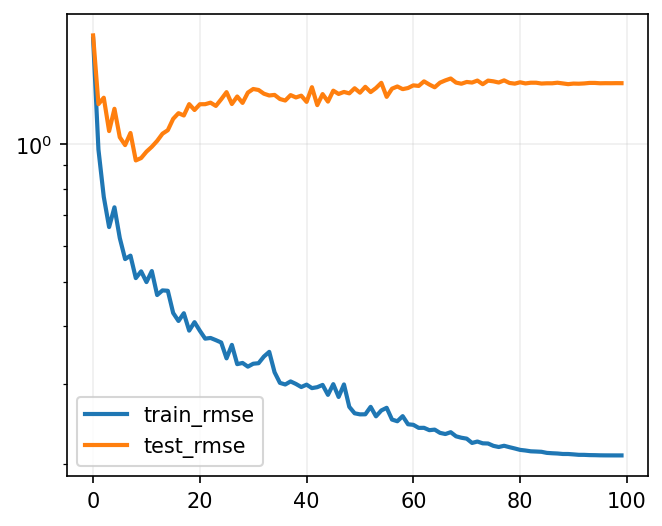

In [41]:
plt.figure(figsize=(5,4), dpi=150)
plt.plot(train_rmse, lw=2.0, label='train_rmse')
plt.plot(test_rmse, lw=2.0, label='test_rmse')
plt.yscale("log")
plt.grid("on", alpha=0.2)
plt.legend()
plt.show()

#### Plot the train test curves

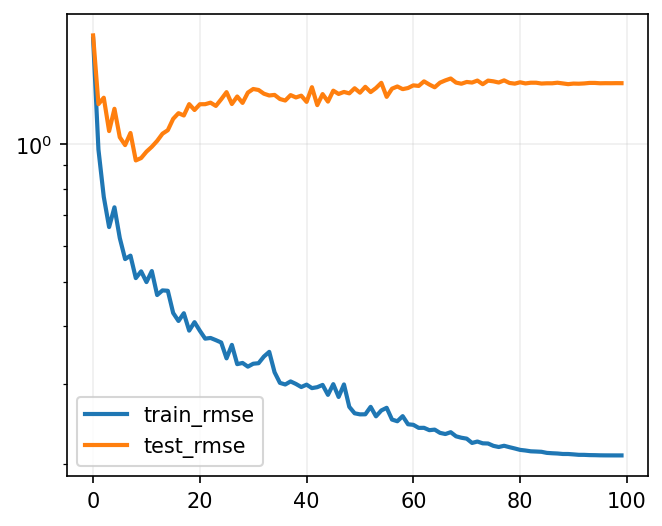

In [42]:
plt.figure(figsize=(5,4), dpi=150)
plt.plot(train_rmse, lw=2.0, label='train_rmse')
plt.plot(test_rmse, lw=2.0, label='test_rmse')
plt.yscale("log")
plt.grid("on", alpha=0.2)
plt.legend()
plt.show()

#### Save the model

In [43]:
load = False

# If load=True, specify the model to load in the below line
MODEL_PATH = "./models/model_weights_test_run_2023-03-21_22:42:45.577525"

In [44]:

if load:
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    MODEL_PATH='./models/model_weights_{}'.format(wandb_run[:22])
    if not os.path.exists('./models'):
        os.mkdir('./models')
    torch.save(model.state_dict(), MODEL_PATH)

RuntimeError: File ./models/model_weights_ice_run_2024-03-14_09: cannot be opened.

In [ ]:
'''
Perform evaluation
'''
train_eval_dict = model.evaluate_batch(X_train.to(device), Y_train.to(device))
test_eval_dict = model.evaluate_batch(X_test.to(device), Y_test.to(device))

In [ ]:
X_test.shape

In [ ]:
X_train.shape

In [ ]:
Y_train.shape

In [ ]:
Y_test.shape

In [ ]:
test_eval_dict['y_true'][1001][2]

In [ ]:
test_eval_dict['y_pred'][1001][2]

## 4. Plotting and Evaluation

In [ ]:
'''
Create plot tables for T+n th predictions
'''
train_gt = train_eval_dict['y_true']
train_gt_df = pd.DataFrame(train_gt.cpu().numpy()[:,:,0])
train_gt_values = np.append(train_gt_df[0].values, train_gt_df.iloc[-1,1:]) # ground-truth values for train data

test_gt = test_eval_dict['y_true']
test_gt_df = pd.DataFrame(test_gt.cpu().numpy()[:,:,0])
test_gt_values = np.append(test_gt_df[0].values, test_gt_df.iloc[-1,1:]) # ground-truth values for test data

train_pred = train_eval_dict['y_pred'] # model predicted values for train data
test_pred = test_eval_dict['y_pred'] # model predicted values for test data

df_train_comp = df_train
#df_train_comp=df_train_comp.rename(columns = {'time':'Date'})
#print(df_train_comp.Date)

df_test_comp = df_test
#df_test_comp=df_test_comp.rename(columns = {'time':'Date'})
#print(df_test_comp.Date)

print(df_train_comp.shape)
print(train_pred.shape)
print(train_gt_values.shape)

train_T_pred_table, train_plot_df, plot_train_gt_values = utils.predictionTable(df_train_comp, train_pred, train_gt_values)

test_T_pred_table, test_plot_df, plot_test_gt_values = utils.predictionTable(df_test_comp, test_pred, test_gt_values)

In [ ]:
'''
Generate the plots on train data
'''

# Specify the list of T+n predictions to plot
horizon_range = [1,7, 14] # this will plot T+1 and T+n predictions w.r.t Ground truth

utils.plotTable(train_plot_df, plot_train_gt_values, horizon_range)

In [ ]:
'''
Generate the plots on test data
'''

# Specify the list of T+n predictions to plot
horizon_range = [1,7,14] # this will plot T+1 and T+n predictions w.r.t Ground truth

utils.plotTable(test_plot_df, plot_test_gt_values, horizon_range)

#### Compute the RMSE values

In [ ]:
'''
Compute train rmse

- Train RMSE values for all T+n th predictions. The index represents the T+n

'''
rmse_values = []
for i in range(output_window):
    rmse_values.append(utils.compute_rmse(i, train_T_pred_table, train_gt_values))
rmse_values = pd.DataFrame(rmse_values, columns=['RMSE'], index=range(1,output_window+1))
rmse_values

In [ ]:
'''
Compute test rmse

- Test RMSE values for all T+n th predictions. The index represents the T+n

'''
test_rmse_values = []
for i in range(output_window):
    test_rmse_values.append(utils.compute_rmse(i, test_T_pred_table, test_gt_values))
test_rmse_values = pd.DataFrame(test_rmse_values, columns=['RMSE'], index=range(1,output_window+1))
test_rmse_values